In [1]:
# !pip install opencv-python

In [2]:
# !pip install torchvision

In [5]:
import torch
import numpy as np
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from torchinfo import summary
import cv2
import matplotlib.pyplot as plt
from deepmag import dataset, viz, model, train

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
torch.cuda.get_device_name()

'NVIDIA A40'

In [7]:
m = torch.load('data/models/20191202-b10-r0.1-lr0.0001-00.pt').to(device)

In [8]:
summary(m, input_size=((1, 3, 544, 960), (1, 3, 544, 960), (1,1)), device='cuda:0')

Layer (type:depth-idx)                             Output Shape              Param #
MagNet                                             [1, 3, 544, 960]          --
├─Encoder: 1-1                                     [1, 32, 136, 240]         --
│    └─Sequential: 2-1                             [1, 32, 272, 480]         --
│    │    └─ReflectionPad2d: 3-1                   [1, 3, 550, 966]          --
│    │    └─Conv2d: 3-2                            [1, 16, 544, 960]         2,368
│    │    └─ReLU: 3-3                              [1, 16, 544, 960]         --
│    │    └─ReflectionPad2d: 3-4                   [1, 16, 546, 962]         --
│    │    └─Conv2d: 3-5                            [1, 32, 272, 480]         4,640
│    │    └─ReLU: 3-6                              [1, 32, 272, 480]         --
│    └─Sequential: 2-2                             [1, 32, 272, 480]         --
│    │    └─ResidualBlock: 3-7                     [1, 32, 272, 480]         18,496
│    │    └─ResidualBlock

(-0.5, 959.5, 543.5, -0.5)

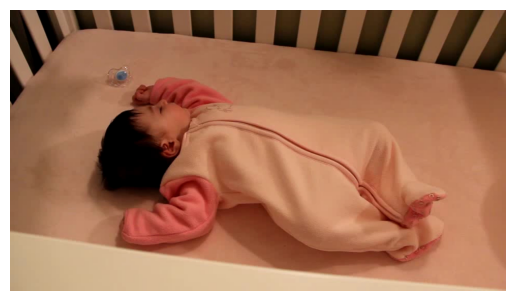

In [9]:
# vid = cv2.VideoCapture('data/examples/baby.mp4')
# vid.set(cv2.CAP_PROP_POS_FRAMES, 0)
# plt.imshow(vid.read()[1][...,::-1])

frame = cv2.imread('data/examples/baby_frames/baby000.jpg')[...,::-1]
plt.imshow(frame)
plt.axis('off')

In [7]:
# preprocess two frames and amplification factor
transform = transforms.Compose([
    transforms.ToTensor()
])

frame_a = cv2.imread('data/examples/baby_frames/baby000.jpg')[...,::-1]
frame_a = torch.unsqueeze(transform(to_pil_image(frame_a)).to(device), 0)
frame_b = cv2.imread('data/examples/baby_frames/baby001.jpg')[...,::-1]
frame_b = torch.unsqueeze(transform(to_pil_image(frame_b)).to(device), 0)

amplification = 100
amp_f_tensor = torch.tensor(
            [[float(amplification)]], dtype=torch.float, device=device)
frame_a.shape

torch.Size([1, 3, 544, 960])

In [8]:
%%timeit
pred, _, _ = m.forward(
    frame_a.to(device),
    frame_b.to(device),
    amp_f_tensor.reshape(1, 1).to(device))

The slowest run took 7.40 times longer than the fastest. This could mean that an intermediate result is being cached.
20.1 ms ± 15.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
# generate predicted motion amlified frame 
pred, _, _ = m.forward(
    frame_a.to(device),
    frame_b.to(device),
    amp_f_tensor.reshape(1, 1).to(device))

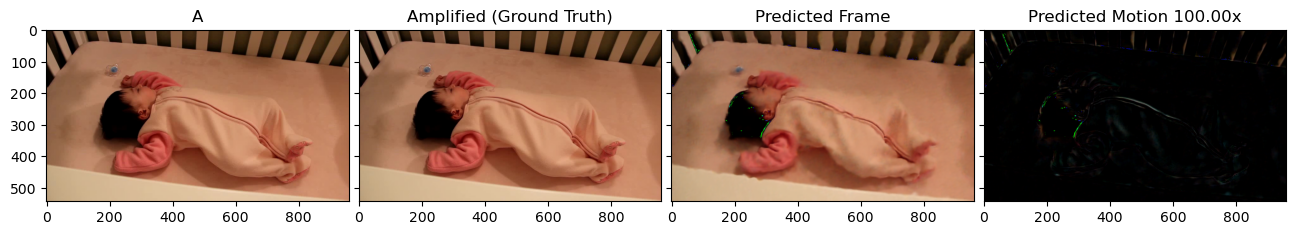

In [10]:
viz.show_pred(frame_a[0],
          frame_b[0],
          amp_f_tensor,
          pred[0].cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 959.5, 543.5, -0.5)

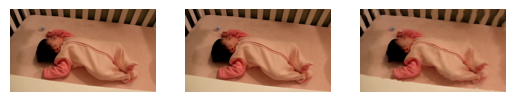

In [11]:
plt.subplot(1,3,1)
plt.imshow(frame_a[0].permute(1,2,0).cpu())
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(frame_b[0].permute(1,2,0).cpu())
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(pred[0].permute(1,2,0).cpu().detach().numpy())
plt.axis('off')

In [12]:
# for i in range(10):
#     print('{:03d}'.format(i))

In [13]:
# save predicted output images from the baby video from each 2-frame pair
# for i in range(300):
#     frame_a = cv2.imread('data/examples/baby_frames/baby' + '{:03d}'.format(i) + '.jpg')[...,::-1]
#     frame_a = torch.unsqueeze(transform(to_pil_image(frame_a)).to(device), 0)
#     frame_b = cv2.imread('data/examples/baby_frames/baby' + '{:03d}'.format(i+1) + '.jpg')[...,::-1]
#     frame_b = torch.unsqueeze(transform(to_pil_image(frame_b)).to(device), 0)
#     pred, _, _ = m.forward(
#         frame_a.to(device),
#         frame_b.to(device),
#         amp_f_tensor.reshape(1, 1).to(device))
#     pred = pred[0].permute(1,2,0).detach().cpu().numpy()[...,::-1]
#     file_path = 'data/examples/baby_frames_output/baby' + '{:03d}'.format(i) + '_output.jpg'
#     cv2.imwrite(file_path, 255*pred)

In [14]:
!python main.py amplify data/models/20191204-b4-r0.1-lr0.0001-05.pt ../custom-video-footage/bas-fhd-30.mp4 --amplification=2

In [23]:
# preprocess two frames and amplification factor
transform = transforms.Compose([
    transforms.ToTensor()
])

frame_a = cv2.imread('data/examples/bas_frames/bas-fhd-30100.jpg')[...,::-1]
frame_a = torch.unsqueeze(transform(to_pil_image(frame_a)).to(device), 0)
frame_b = cv2.imread('data/examples/bas_frames/bas-fhd-30101.jpg')[...,::-1]
frame_b = torch.unsqueeze(transform(to_pil_image(frame_b)).to(device), 0)

amplification = 10
amp_f_tensor = torch.tensor(
            [[float(amplification)]], dtype=torch.float, device=device)
frame_a.shape

torch.Size([1, 3, 1080, 1920])

In [24]:
# generate predicted motion amlified frame 
pred, _, _ = m.forward(
    frame_a.to(device),
    frame_b.to(device),
    amp_f_tensor.reshape(1, 1).to(device))

In [25]:
%%timeit
pred, _, _ = m.forward(
    frame_a.to(device),
    frame_b.to(device),
    amp_f_tensor.reshape(1, 1).to(device))

151 ms ± 4.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


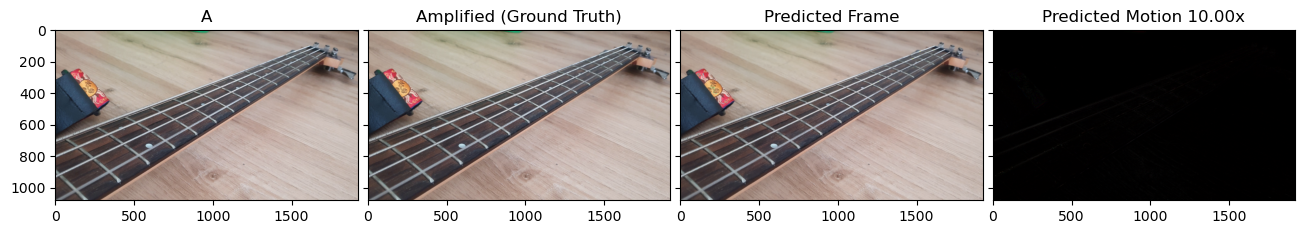

In [26]:
viz.show_pred(frame_a[0],
          frame_b[0],
          amp_f_tensor,
          pred[0].cpu())